In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import warnings
warnings.filterwarnings("ignore")

In [3]:
import scanpy as sc
from scpy4reactome import scanpy_wrapper

dir = '/Volumes/ssd/results/missy_sc_rna/uvm/'

filename = dir + 'rna_adatas/rna_UMM063.h5ad'
adata = sc.read_h5ad(filename)
scanpy_wrapper.preprocess(adata)
adata

AnnData object with n_obs × n_vars = 3072 × 18984
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'doublet', 'celltype_orig', 'Tum_Score1', 'Mac_Score1', 'celltype_hybrid_high_only', 'celltype_hybrid_high_medium', 'SCT_snn_res.0.8', 'seurat_clusters', 'Tumor1', 'T_cell1', 'B_cell1', 'Plasma_cell1', 'Monocytes_and_macrophages1', 'NK_cell1', 'Fibroblasts1', 'Endothelial_cell1', 'New_Cell_Type', 'pANN_0.25_0.09_4494', 'DF.classifications_0.25_0.09_4494', 'DoubletScore', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [2]:
filename = dir + 'sct_adatas/UMM063.h5ad'
sct_adata = sc.read_h5ad(filename)
sct_adata
# sct_adata.obs['IL1B'] = adata.obs_vector('IL1B')

TypeError: unsupported operand type(s) for +: 'builtin_function_or_method' and 'str'

In [9]:
sct_adata = sct_adata[adata.obs_names, :]
sct_adata

View of AnnData object with n_obs × n_vars = 3072 × 3000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'doublet', 'celltype_orig', 'Tum_Score1', 'Mac_Score1', 'celltype_hybrid_high_only', 'celltype_hybrid_high_medium', 'SCT_snn_res.0.8', 'seurat_clusters', 'Tumor1', 'T_cell1', 'B_cell1', 'Plasma_cell1', 'Monocytes_and_macrophages1', 'NK_cell1', 'Fibroblasts1', 'Endothelial_cell1', 'New_Cell_Type', 'pANN_0.25_0.09_4494', 'DF.classifications_0.25_0.09_4494', 'DoubletScore'
    var: 'features'
    uns: 'neighbors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances'

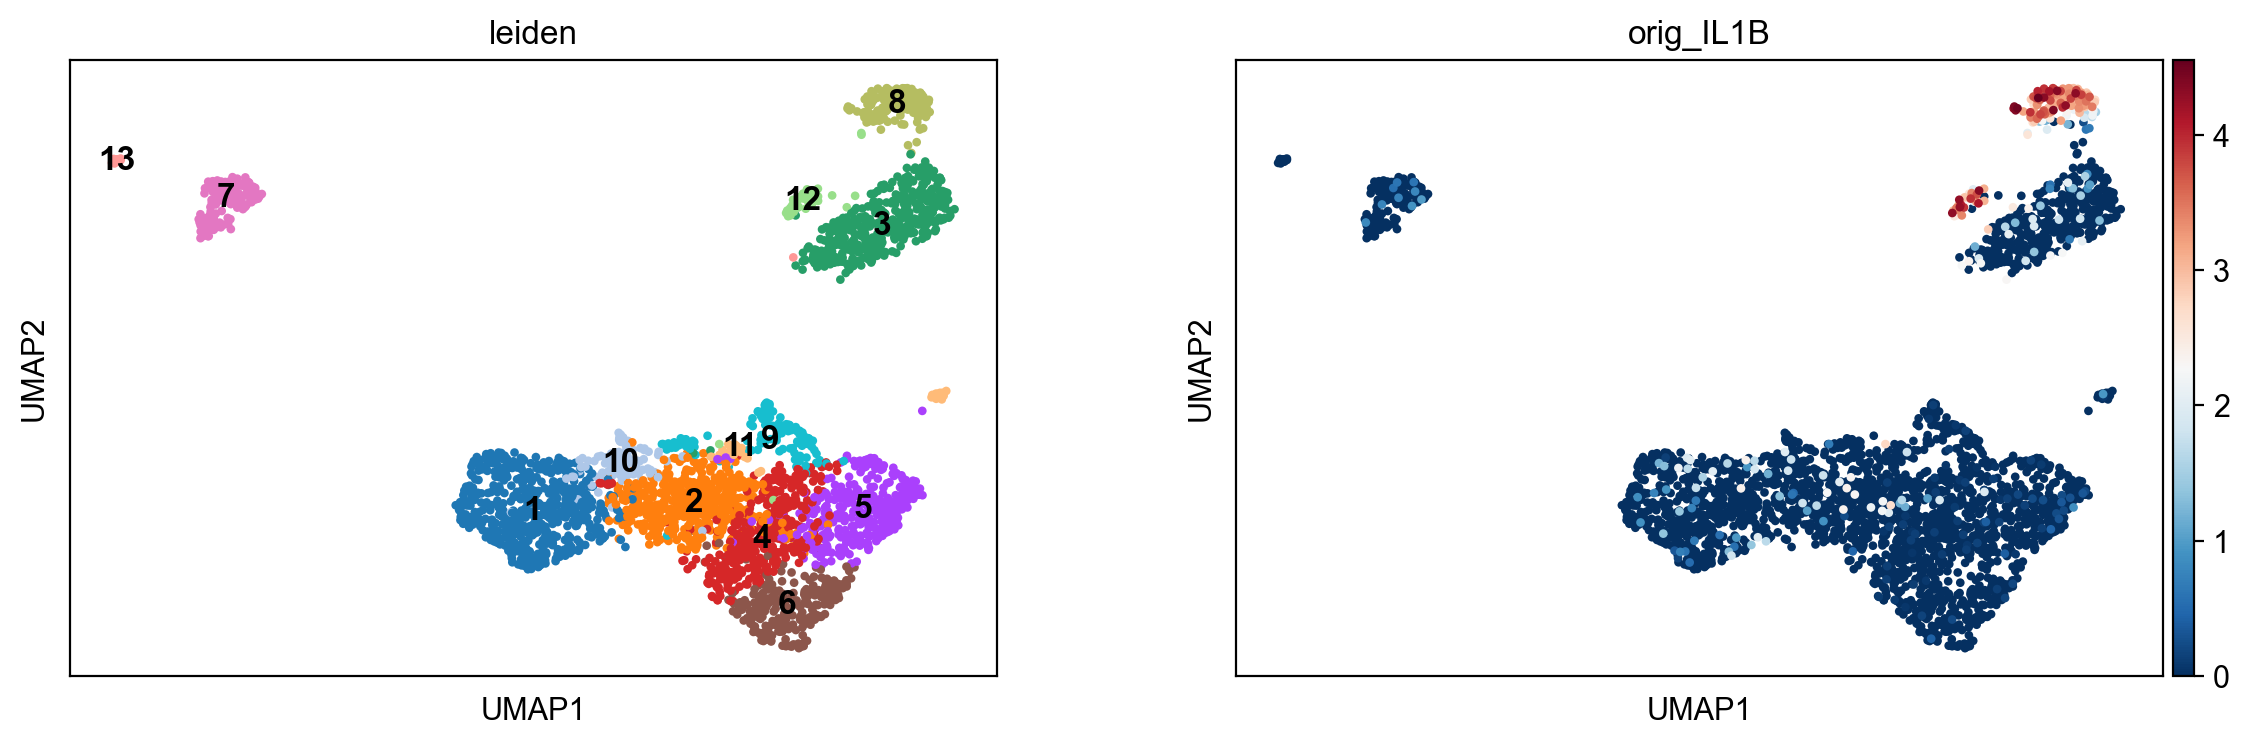

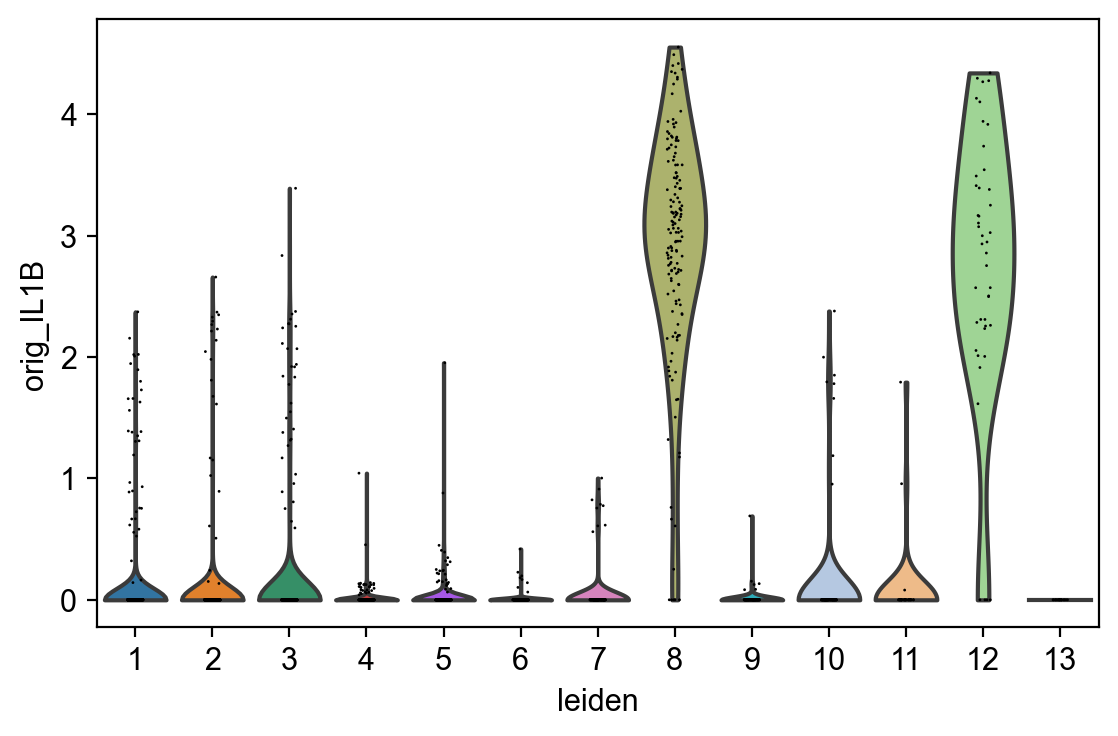

In [12]:
import pandas as pd

sct_adata.obs['leiden'] = pd.Categorical(sct_adata.obs['seurat_clusters'] + 1)

sct_adata.obs['orig_IL1B'] = adata.obs_vector('IL1B')
sc.pl.umap(sct_adata, color = ['leiden', 'orig_IL1B'], legend_loc = 'on data')
sc.pl.violin(sct_adata, 'orig_IL1B', groupby='leiden')

/Users/wug/miniconda3/envs/scenicplus/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


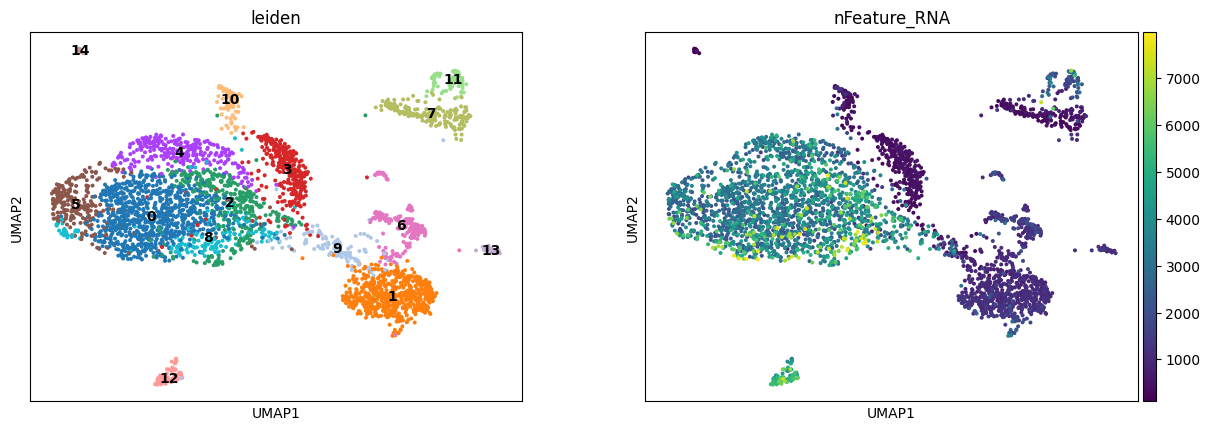

In [15]:
import pandas as pd

umm059_adata.obs['leiden'] = pd.Categorical(umm059_adata.obs['seurat_clusters'])

sc.pl.umap(umm059_adata, color=['leiden', 'nFeature_RNA'], legend_loc='on data')

In [6]:
raw_file = dir + 'UMM059/umm059_rna_counts.csv'
raw_count = pd.read_csv(raw_file, index_col=0)
print(raw_count.shape)

TypeError: unsupported operand type(s) for +: 'builtin_function_or_method' and 'str'

In [67]:
umm059_adata_raw = sc.AnnData(X=raw_count.T)
umm059_adata_raw.obs = umm059_adata.obs
umm059_adata_raw.uns = umm059_adata.uns
umm059_adata_raw.obsm = umm059_adata.obsm

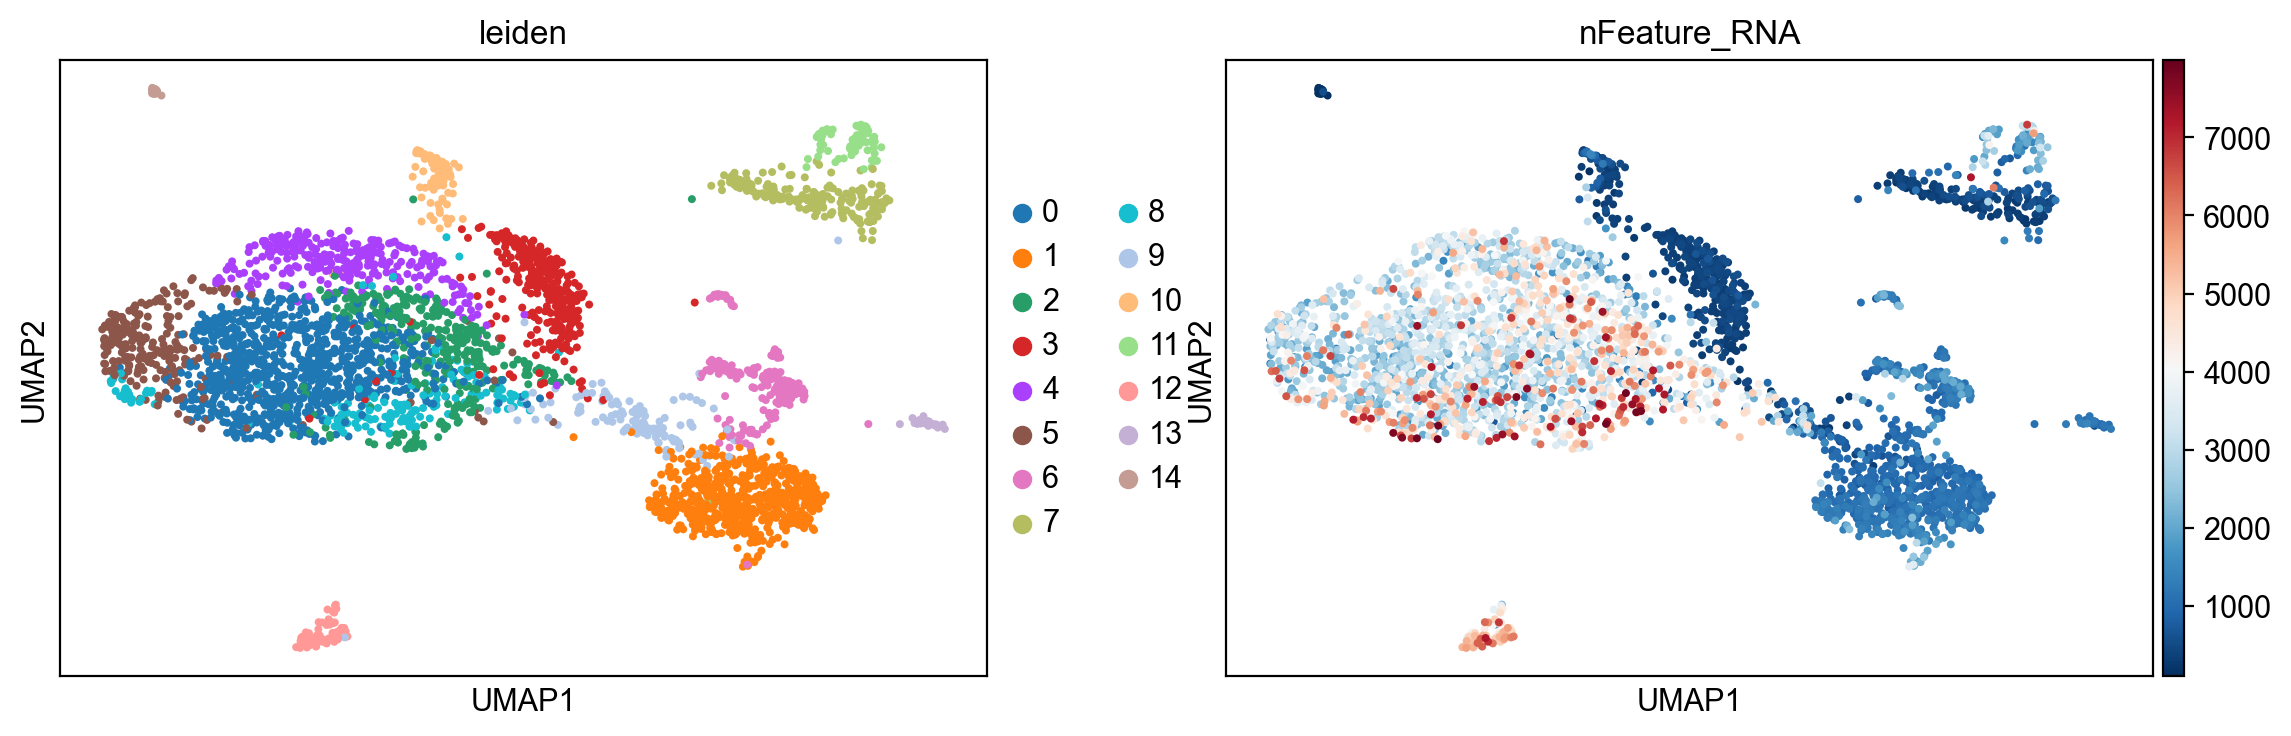

In [68]:
sc.pl.umap(umm059_adata_raw, color=['leiden', 'nFeature_RNA'])

In [5]:
import sys
sys.path.append('../scripts/Python/')

import utils

cytotrace_result = utils.run_cytotrace(adata=adata)

processing: 5.207905054092407
markov: 0.5124330520629883
gcs: 0.41917991638183594
fnnls
regression: 3.6761438846588135
diffusion:0.11419320106506348 
genes:0.38263607025146484


In [77]:
umm059_adata_raw.obs['cytotrace'] = cytotrace_result['CytoTRACE']
sc.write(dir + 'UMM059/UMM059_raw.h5ad', umm059_adata_raw)

... storing 'cytotrace' as categorical


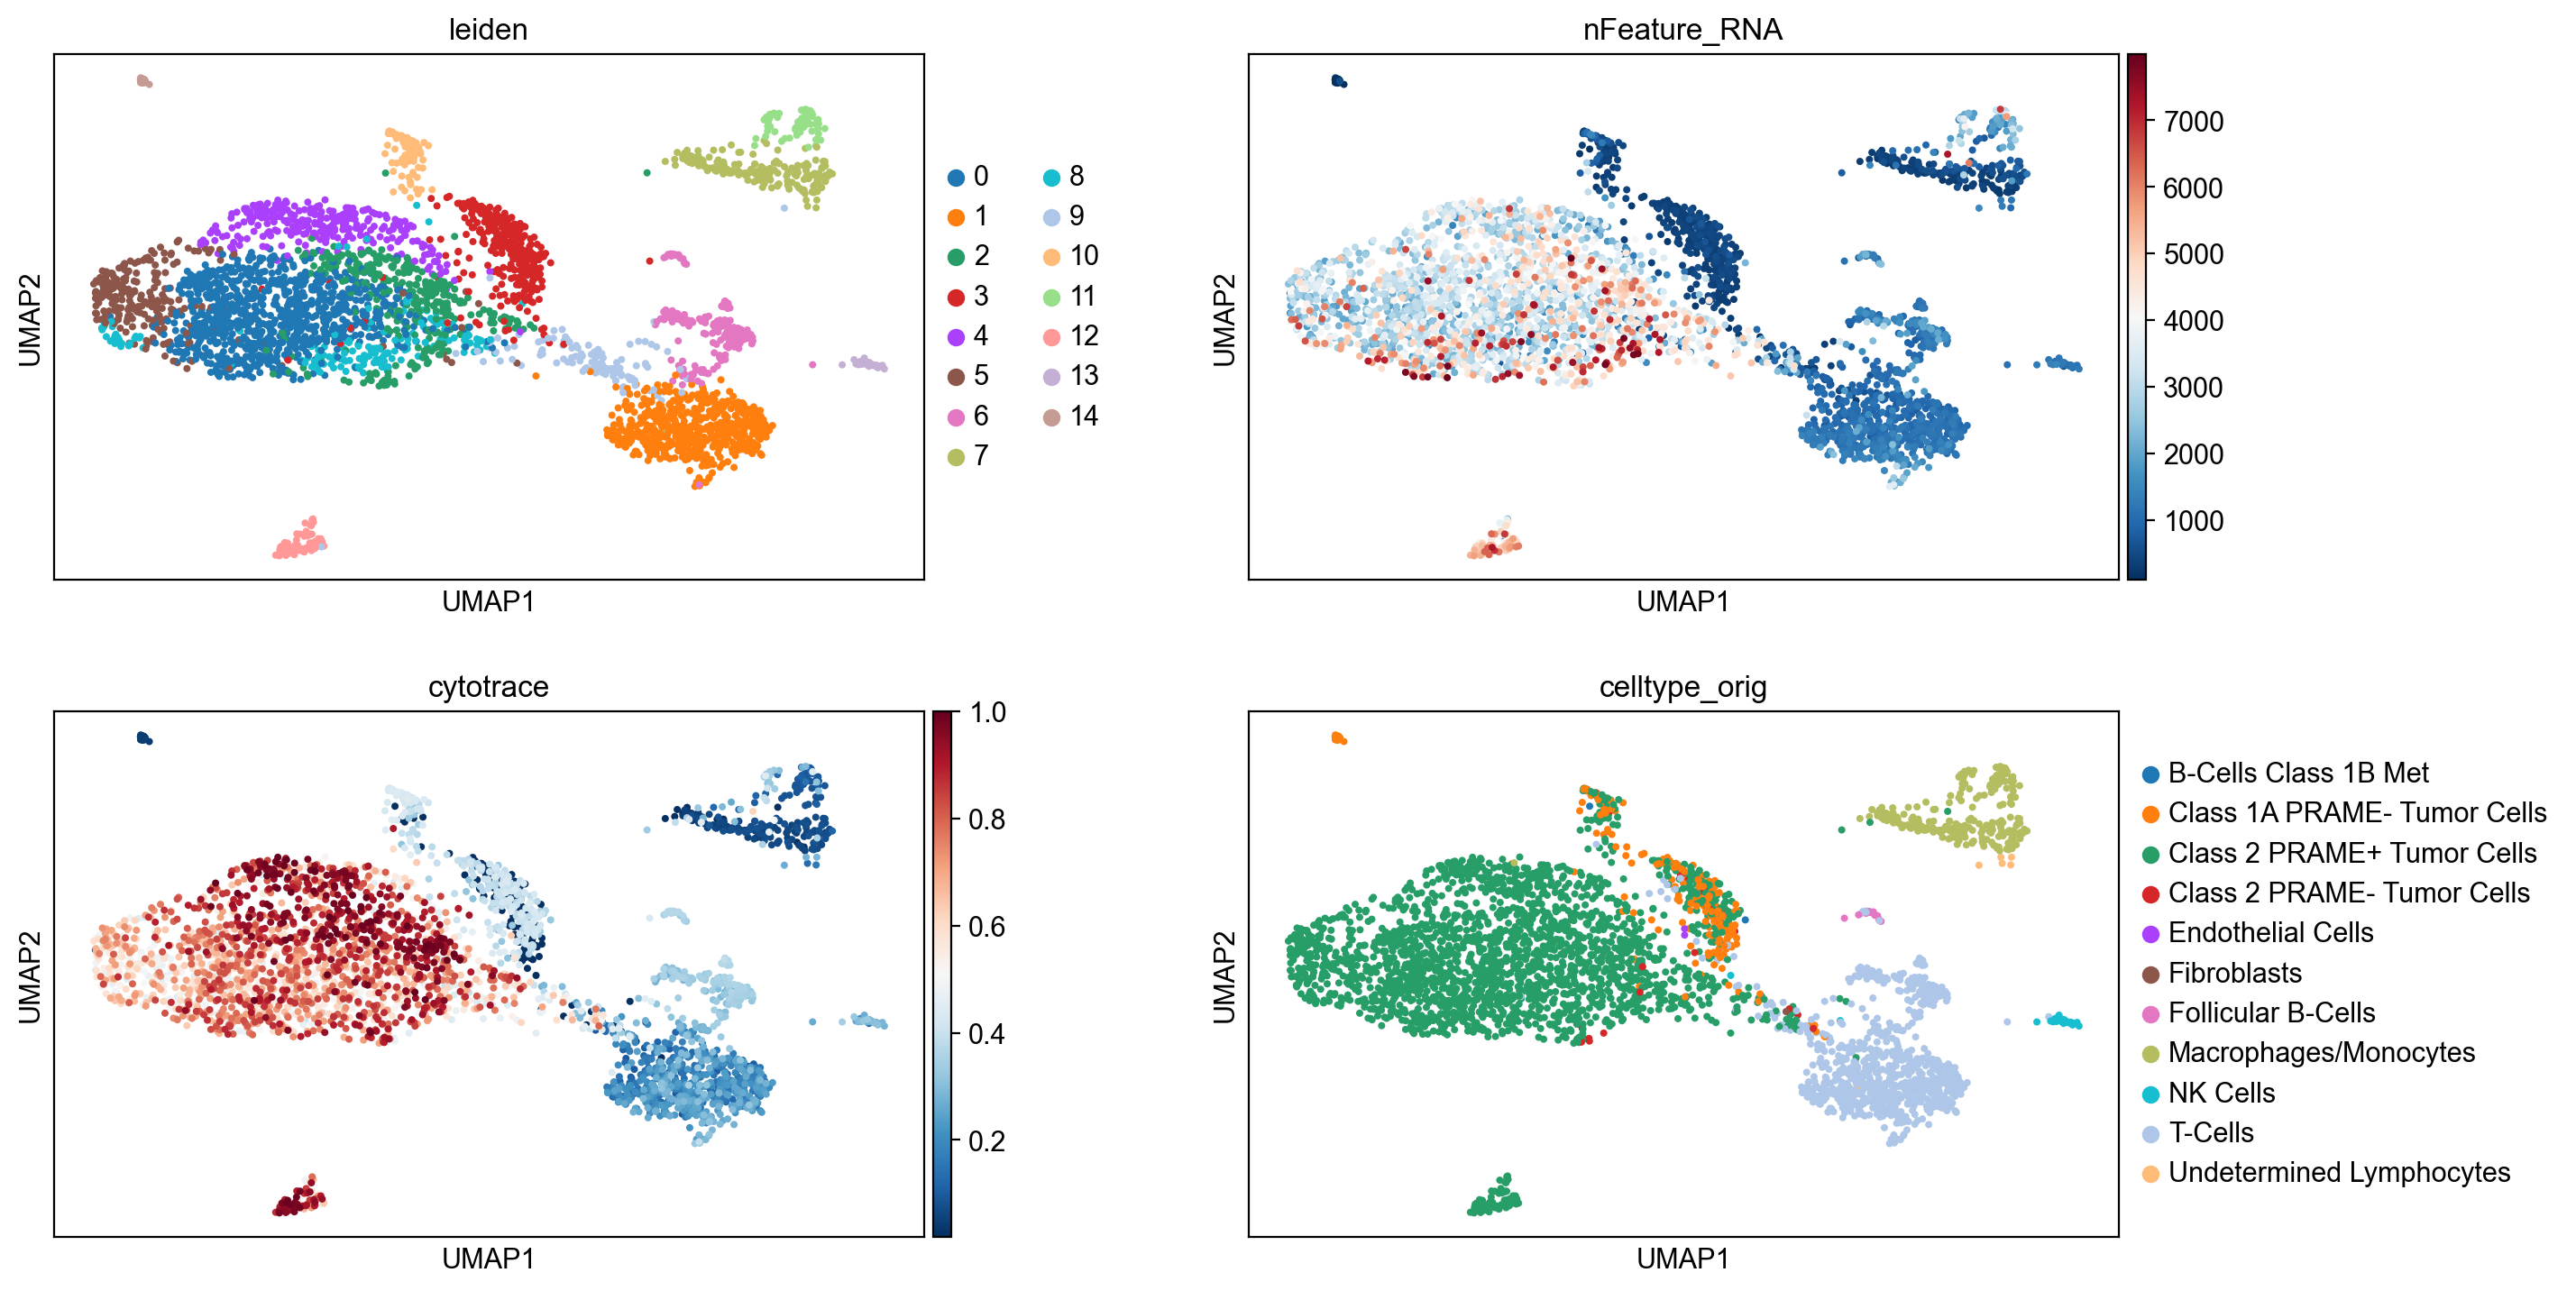

In [80]:
sc.pl.umap(umm059_adata_raw, color=['leiden', 'nFeature_RNA', 'cytotrace', 'celltype_orig'], wspace=0.25, ncols=2)

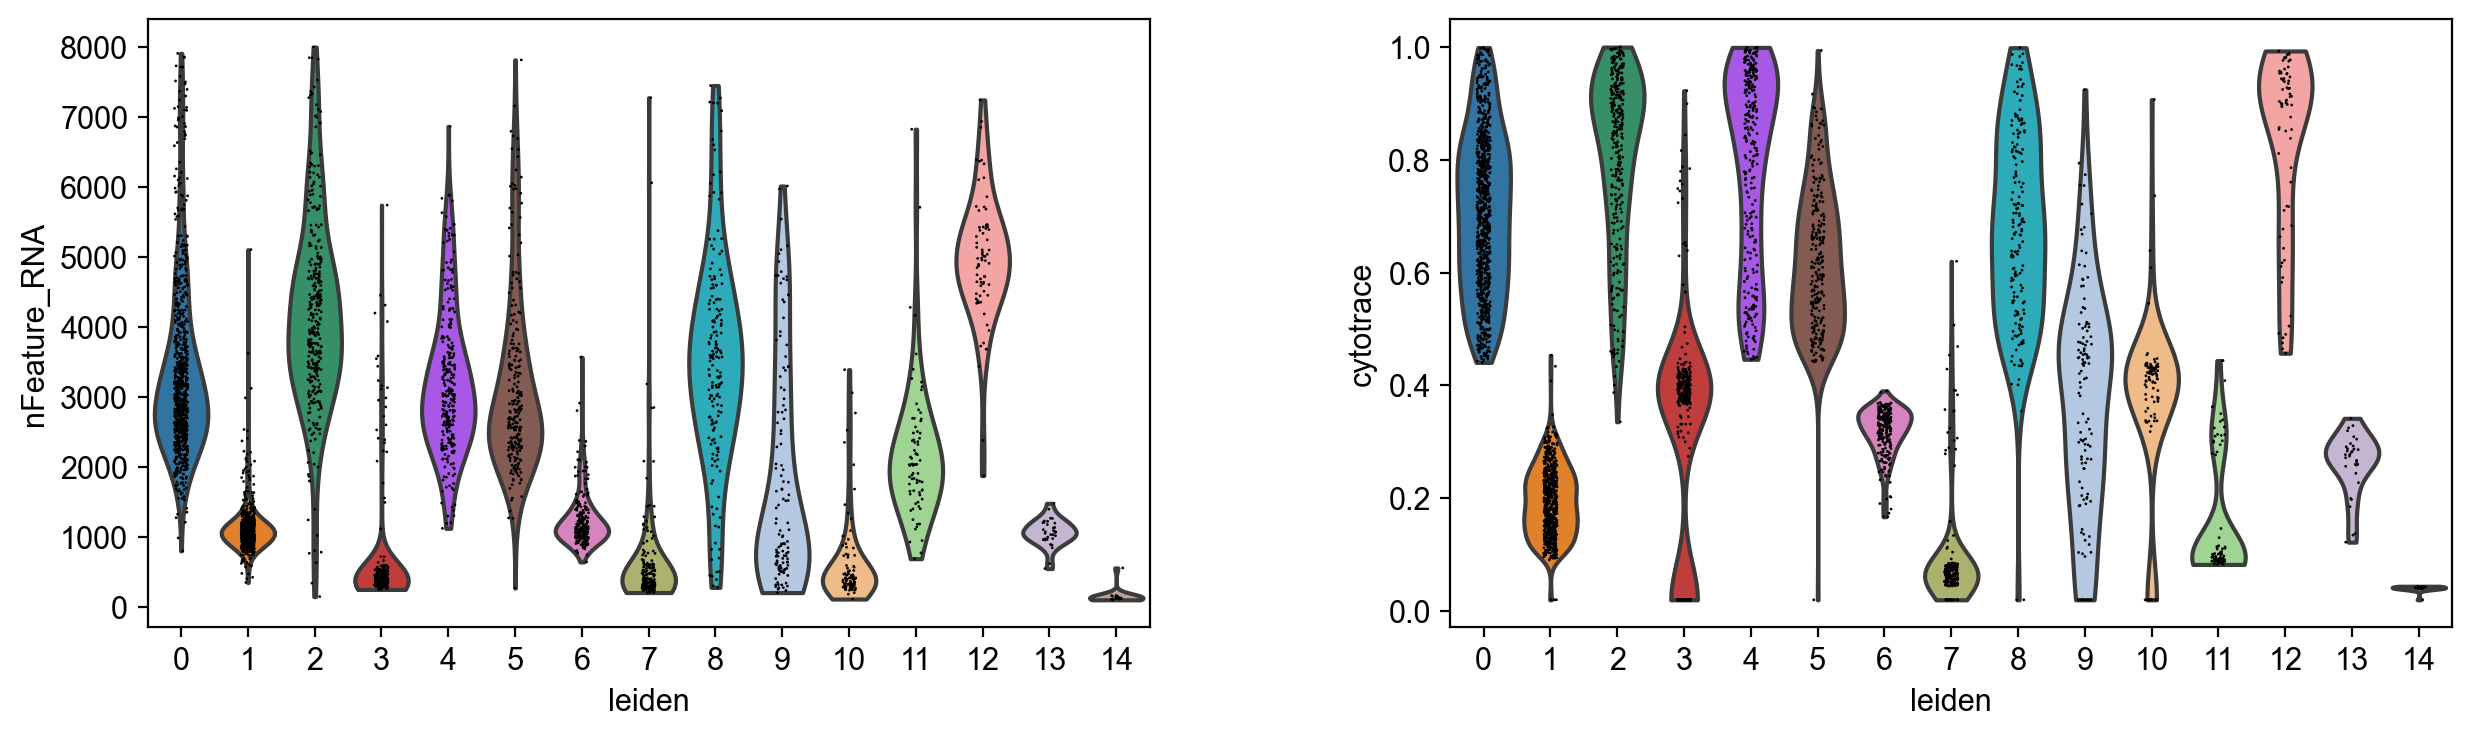

In [88]:
sc.pl.violin(umm059_adata_raw, keys=['nFeature_RNA', 'cytotrace'], groupby='leiden', ncols=2)

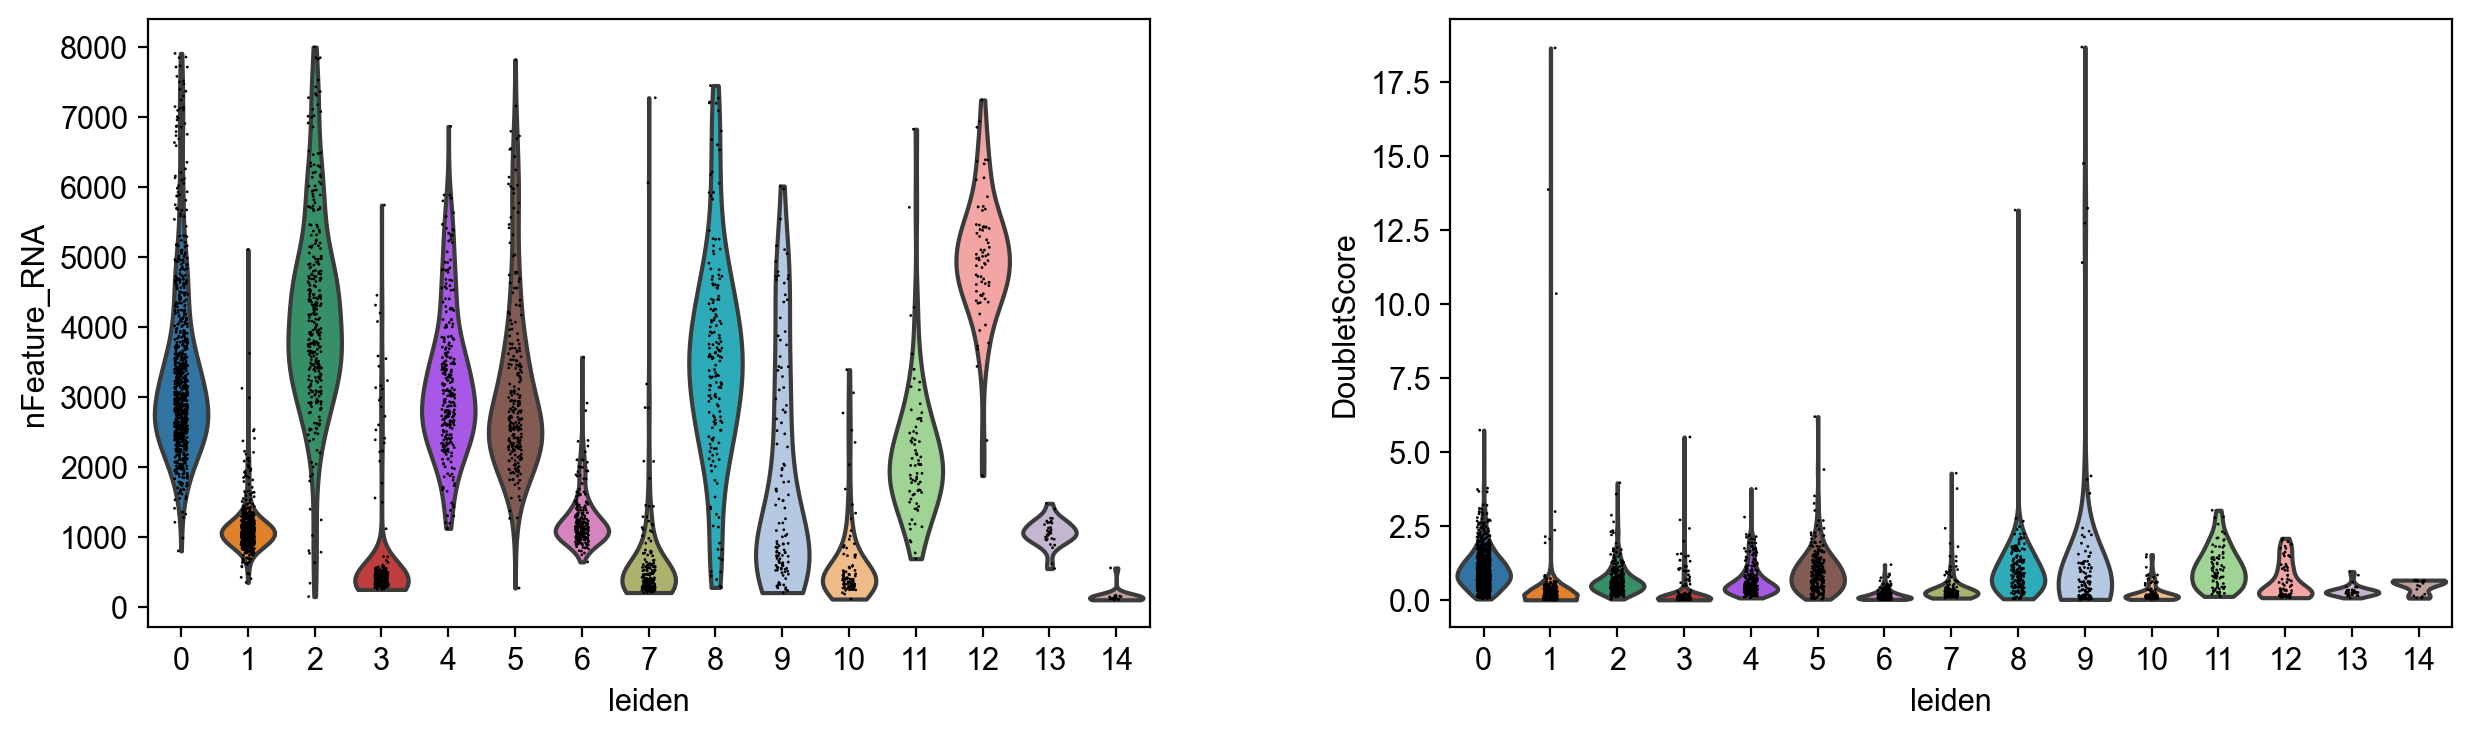

In [89]:
sc.pl.violin(umm059_adata_raw, keys=['nFeature_RNA', 'DoubletScore'], groupby='leiden', ncols=2)

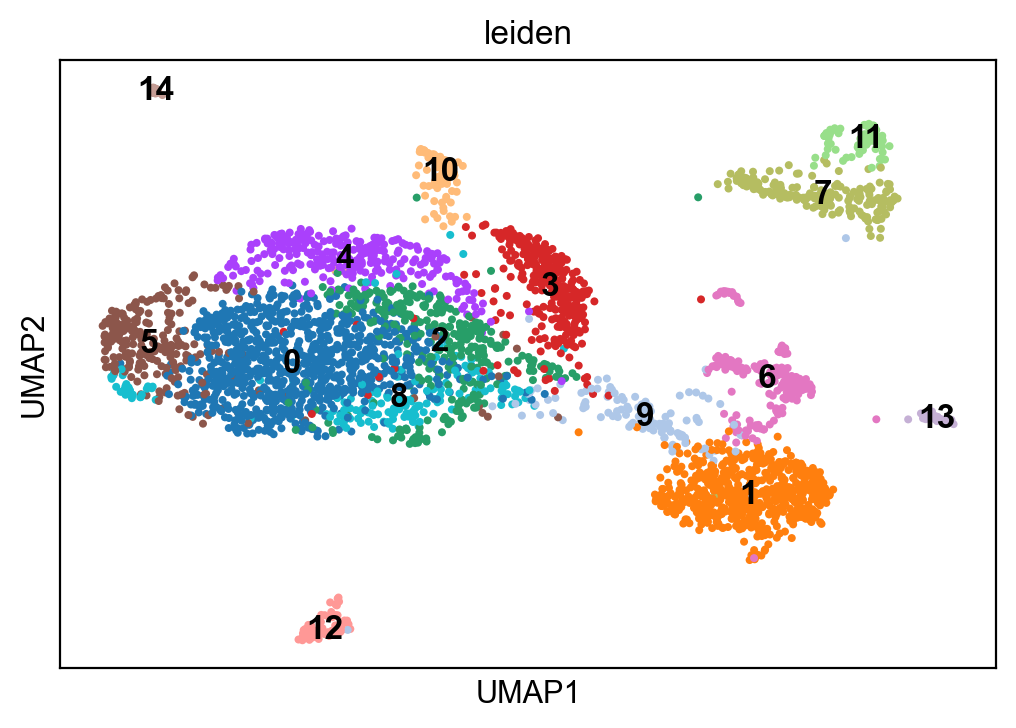

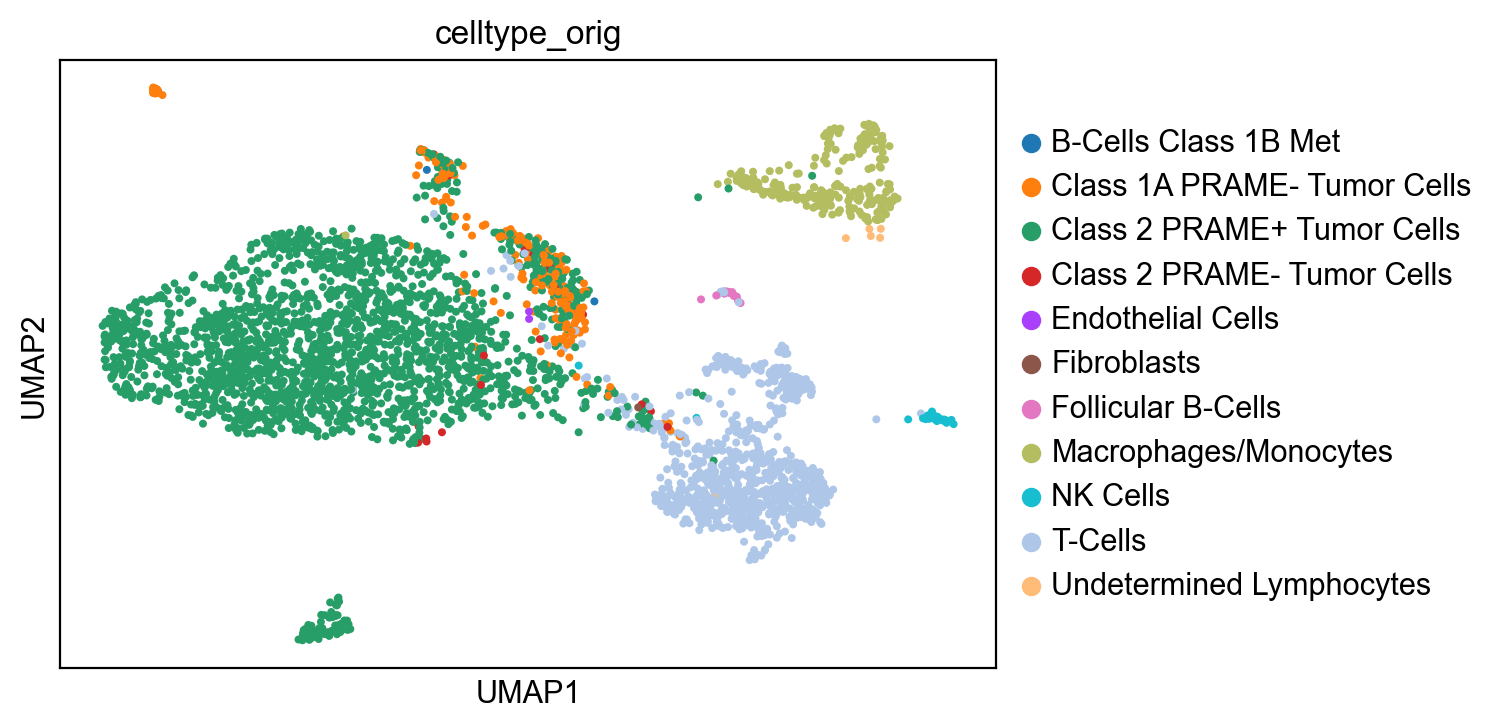

In [91]:
sc.pl.umap(umm059_adata_raw, color=['leiden'], legend_loc='on data')
sc.pl.umap(umm059_adata_raw, color=['celltype_orig'])

In [96]:
import doubletdetection

clf = doubletdetection.BoostClassifier(clustering_algorithm='leiden')
doublets = clf.fit(umm059_adata_raw.X).predict(p_thresh=1E-16, voter_thresh=0.5)
doublet_score = clf.doublet_score()

  0%|          | 0/10 [00:00<?, ?it/s]

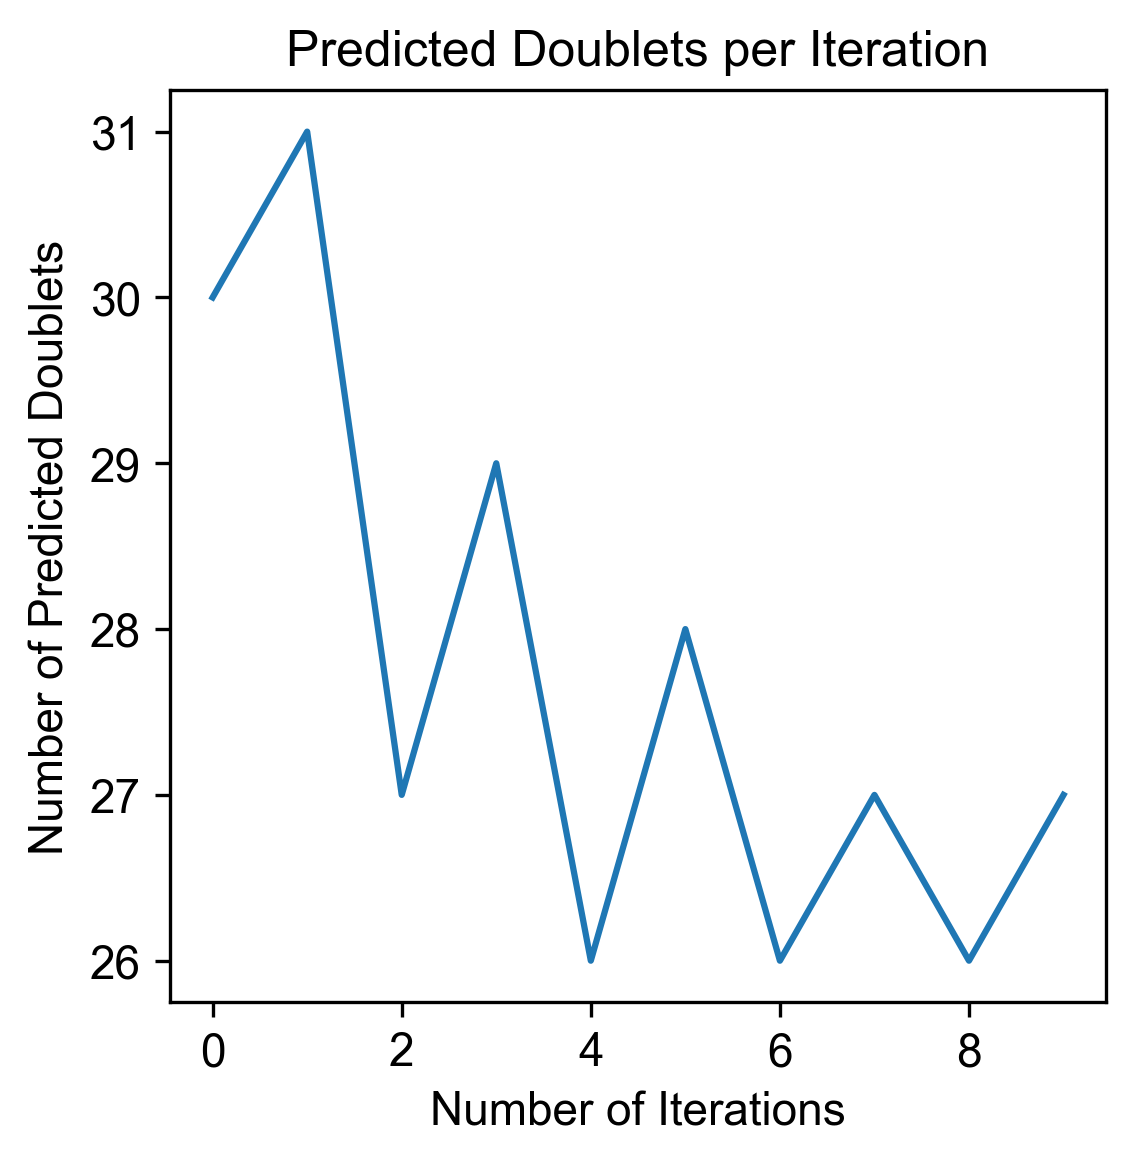

In [97]:
f = doubletdetection.plot.convergence(clf, save='convergence_test.pdf', show=True, p_thresh=1e-16, voter_thresh=0.5)

In [98]:
umm059_adata_raw.obs["doublet"] = doublets
umm059_adata_raw.obs["doublet_score"] = doublet_score

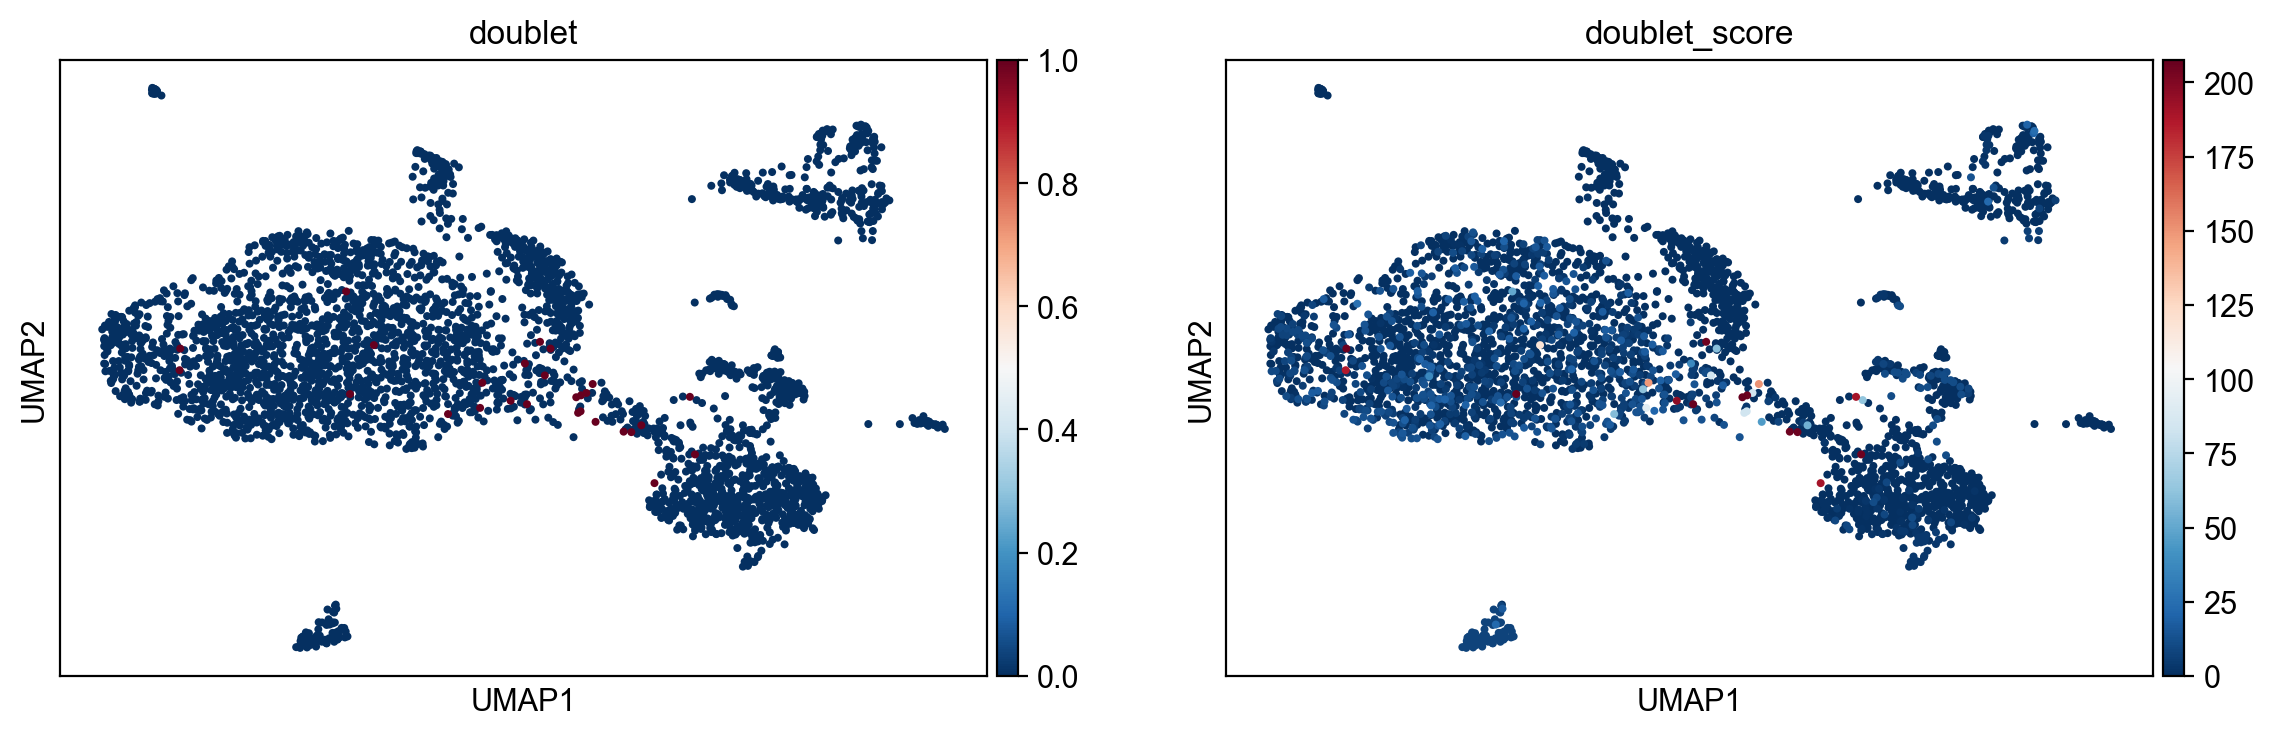

In [99]:
sc.pl.umap(umm059_adata_raw, color=['doublet', 'doublet_score'])

In [104]:
umm059_adata_raw

AnnData object with n_obs × n_vars = 3618 × 18355
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'doublet', 'celltype_orig', 'Tum_Score1', 'Mac_Score1', 'celltype_hybrid_high_only', 'celltype_hybrid_high_medium', 'SCT_snn_res.0.8', 'seurat_clusters', 'Tumor1', 'T_cell1', 'B_cell1', 'Plasma_cell1', 'Monocytes_and_macrophages1', 'NK_cell1', 'Fibroblasts1', 'Endothelial_cell1', 'New_Cell_Type', 'pANN_0.25_0.09_4494', 'DF.classifications_0.25_0.09_4494', 'DoubletScore', 'leidn', 'leiden', 'gcs', 'cytotrace', 'counts', 'doublet_score'
    var: 'cytotrace', 'cytotrace_corrs'
    uns: 'neighbors', 'doublet_colors', 'leiden_colors', 'celltype_orig_colors'
    obsm: 'X_pca', 'X_umap'

In [1]:
import scanpy as sc

adata_raw = sc.read_h5ad('/Volumes/ssd/results/missy_sc_rna/uvm/UMM059/UMM059_raw.h5ad')

In [15]:
import scrublet as scr
import pandas as pd

scrub = scr.Scrublet(adata_raw.X)
doublet_scores, predicted_doublets = scrub.scrub_doublets()
adata_raw.obs['scrublet_doublet_score'] = doublet_scores
adata_raw.obs['scrublet_doublet'] = pd.Categorical(predicted_doublets)

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.46
Detected doublet rate = 1.2%
Estimated detectable doublet fraction = 26.7%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 4.7%
Elapsed time: 5.4 seconds


In [1]:
import scanpy as sc
filename = '/Volumes/ssd/results/missy_sc_rna/uvm/UMM059/UMM059_raw_scrublet.h5ad'
# sc.write(filename, adata_raw)
adata_raw = sc.read_h5ad(filename)

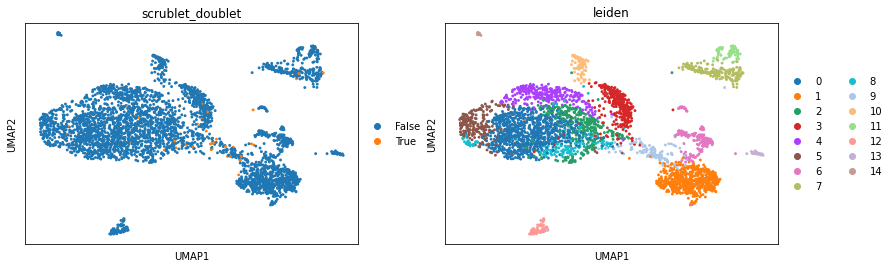

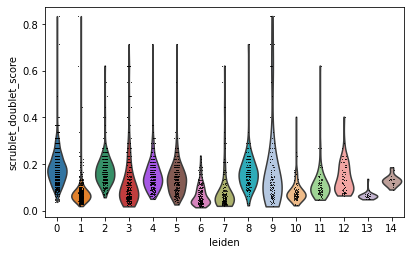

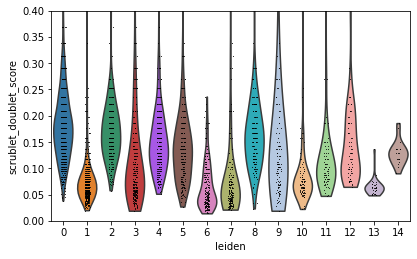

In [26]:
import matplotlib.pyplot as plt

sc.pl.umap(adata_raw, color=['scrublet_doublet', 'leiden'])
sc.pl.violin(adata_raw, keys=['scrublet_doublet_score'], groupby='leiden')
ax = sc.pl.violin(adata_raw, keys=['scrublet_doublet_score'], groupby='leiden', show=False)
ax.set_ylim(0, 0.4)
plt.show()

In [8]:
import pandas as pd
import statsmodels.api as sm
from itertools import combinations

# Assuming you have a dataframe called 'df'
# with columns: 'column1', 'group', ...

# Get unique group labels
def perform_pairwise_t_test(group='batch', score='scrublet_doublet_score'):
    df = adata_raw.obs
    # Create an empty dataframe to store the results
    results_df = pd.DataFrame(columns=['Group 1', 'Group 2', 'T-Statistic', 'P-Value'])
    # Get unique group labels
    groups = df[group].unique()
    # Perform pairwise t-tests
    for group1, group2 in combinations(groups, 2):
        data_group1 = df[df[group] == group1][score]
        data_group2 = df[df[group] == group2][score]
        
        t_statistic, p_value, _ = sm.stats.ttest_ind(data_group1, data_group2)
        
        # Add the results to the dataframe
        results_df = results_df.append({'Group 1': group1, 'Group 2': group2, 'T-Statistic': t_statistic, 'P-Value': p_value}, ignore_index=True)
    return results_df

pairwise_t_test_df = perform_pairwise_t_test('leiden')
HTML(pairwise_t_test_df.sort_values(by='T-Statistic').to_html())

In [18]:
which = (pairwise_t_test_df['Group 1'] == 7.0) | (pairwise_t_test_df['Group 2'] == 7.0)
pairwise_t_test_df[which].sort_values('P-Value')

Group 1  Group 2  T-Statistic       P-Value
68       0.0      7.0    16.563686  7.128947e-55
83       2.0      7.0    12.688027  2.777247e-32
103      4.0      7.0     9.323127  4.581420e-19
76       8.0      7.0     9.002750  1.259235e-17
104      5.0      7.0     7.100569  5.095838e-12
59       9.0      7.0     6.322983  8.903125e-10
38      12.0      7.0     4.879666  1.854989e-06
101      3.0      7.0     4.544197  6.925515e-06
89      11.0      7.0     2.513670  1.254395e-02
94      14.0      7.0     2.192971  2.941818e-02
26       6.0      7.0    -2.027755  4.323952e-02
13       1.0      7.0    -1.282751  1.999494e-01
98      13.0      7.0    -1.084307  2.794048e-01
49      10.0      7.0     0.134455  8.931380e-01

        cell_count  doublet_count  percentage  scrublet_doublet_score_median
leiden                                                                      
9              122             14    0.114754                       0.110184
3              310             13    0.041935                       0.086567
7              191              3    0.015707                       0.052632
11              75              1    0.013333                       0.094340
2              325              4    0.012308                       0.166667
8              174              2    0.011494                       0.158129
5              246              2    0.008130                       0.129594
4              276              1    0.003623                       0.142857
0              852              3    0.003521                       0.175904
1              614              2    0.003257                       0.067358
6              216              0    0.000000                       0.052632

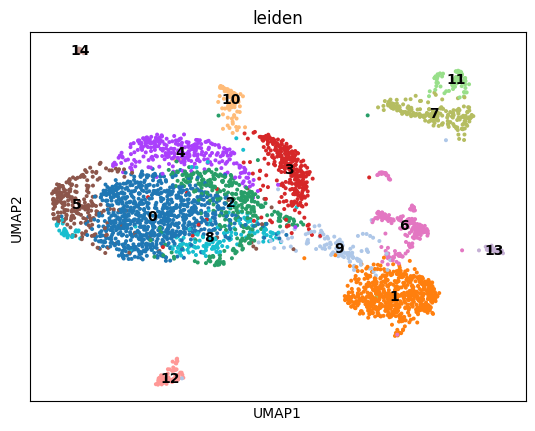

In [34]:
tmp = adata_raw.obs[['scrublet_doublet_score', 'leiden']]
tmp_median = tmp.groupby('leiden').median()
# print(tmp_median)

tmp = adata_raw.obs[['leiden', 'scrublet_doublet']]
tmp['cell_count'] = tmp['scrublet_doublet'].map(lambda v : 1 if v else 0)
tmp['cell_count'] = tmp['cell_count'].astype('int')
tmp_1 = tmp[['leiden', 'cell_count']]
total_cells = tmp_1.groupby('leiden').count()
total_doublet = tmp_1.groupby('leiden')['cell_count'].sum()
leiden_df = pd.DataFrame(total_cells)
leiden_df['doublet_count'] = total_doublet
leiden_df['percentage'] = leiden_df['doublet_count']/leiden_df['cell_count']
leiden_df = leiden_df.join(tmp_median, on='leiden')
leiden_df = leiden_df.rename(columns={'scrublet_doublet_score': 'scrublet_doublet_score_median'})
leiden_df.sort_values(by='percentage', ascending=False, inplace=True)
print(leiden_df)
sc.pl.umap(adata_raw, color='leiden', legend_loc='on data')